# Unit 5: Model-based Collaborative Filtering for **Rating** Prediction

In this unit we change the approach towards Collaborative Filtering (CF) from neighborhood-based to model-based. This means that we create and train a model for describing users and items instead of using the k nearest neighbors.

Key to this idea is to compress the sparse interaction information of $R$ by finding two matrices $U$ and $V$ that by multiplication reconstruct $R$. The decomposition of $R$ into $U \times V$ is called _matrix factorization_ and we refer to $U$ as user latent factor matrix and $V$ as item latent factor matrix.

Compressing the sparse matrix into the product of two matrices means that the two remaining matrices are much smaller. This decrease in size is governed by the dimension of latent user/item vectors and symbolized by $d \in \mathbb{N}$. We choose $d$ to be much smaller than the number of items or users:

\begin{equation*}
\underset{m\times n}{\mathrm{R}} \approx  \underset{m\times d}{U} \times \underset{d\times n}{V^T} \\
d \ll \min\{m, n\}
\end{equation*}

In [14]:
%load_ext autoreload
%autoreload 2

from typing import Dict, List, Tuple
import os
import sys
import math

import numpy as np
import scipy as sp
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from recsys_training.data import Dataset
from recsys_training.evaluation import get_relevant_items

In [16]:
ml100k_ratings_filepath = '../data/raw/ml-100k/u.data'

## Load Data

In [17]:
data = Dataset(ml100k_ratings_filepath)
data.rating_split(seed=42)

As we want to learn the user/item latent factors from rating data, we first randomly initialize them

In [18]:
seed = 42
m = data.n_users
n = data.n_items
d = 10

In [19]:
user_ratings = {}
grouped = data.train_ratings[['user', 'item', 'rating']].groupby('user')
for user in data.users:
    vals = grouped.get_group(user)[['item', 'rating']].values
    user_ratings[user] = dict(zip(vals[:, 0].astype(int),
                                  vals[:, 1].astype(float)))

In [20]:
np.random.seed(seed)
user_factors = np.random.normal(0, 1, (m, d))
item_factors = np.random.normal(0, 1, (n, d))
ratings = data.train_ratings[['user', 'item', 'rating']].sample(frac=1, random_state=seed)

## Training

We fit the model to the data with a technique called minibatch gradient descent.

This means that for a number of epochs, i.e. full passes through the training data (ratings), we randomly choose a small subset of ratings (our minibatch) holding user, item and rating for each instance. Then, we compute the rating prediction as the dot product of user and item latent vectors (also called embeddings) and compute the mean squared error between predicted and true rating. We derive this error for user and item latent vectors to obtain our partial derivatives. They are called gradients and we subtract them from out latent vectors to adjust them to better fit the data minimizing the error, i.e. deviation between true values and predictions.

To keep track of the decreasing error, we compute the root mean sqaured error and print it.

In [21]:
epochs = 3
batch_size = 64
learning_rate = 0.01

num_batches = int(np.ceil(len(ratings) / batch_size))
rmse_trace = []

In [22]:
def compute_gradients(rating: float, u: np.array, v: np.array) -> Tuple[np.array, np.array]:
    pred = np.sum(u * v, axis=1)
    error = (rating - pred).reshape(-1, 1)

    u_grad = -2 * error * v
    v_grad = -2 * error * u

    return u_grad, v_grad

In [23]:
def get_rmse(rating, u, v) -> float:
    pred = np.sum(u * v, axis=1)
    error = rating - pred
    rmse = np.sqrt(np.mean(error ** 2))
    return rmse

In [24]:
for epoch in range(epochs):
    for idx in range(num_batches):
        
        minibatch = ratings.iloc[idx * batch_size:(idx + 1) * batch_size]
        
        # deduct 1 as user ids are 1-indexed, but array is 0-indexed
        user_embeds = user_factors[minibatch['user'].values - 1]
        item_embeds = item_factors[minibatch['item'].values - 1]

        user_grads, item_grads = compute_gradients(minibatch['rating'].values,
                                                   user_embeds,
                                                   item_embeds)
        
        # update user and item factors
        user_factors[minibatch['user'].values - 1] -= learning_rate * user_grads
        item_factors[minibatch['item'].values - 1] -= learning_rate * item_grads

        if not idx % 100:
            rmse = get_rmse(minibatch['rating'].values,
                            user_embeds,
                            item_embeds)
            rmse_trace.append(rmse)
            print(f"{rmse:.3f}")

4.908
4.310
4.458
3.601
3.799
3.379
2.451
2.421
1.922
1.733
1.996
1.191
1.672
1.391
1.349
1.340
1.118
1.246
1.302
1.114
0.902
1.152
1.164
1.221
0.933
1.115
1.145
1.126
1.109
0.934
1.046
1.037
1.026
0.775
1.053
1.078
1.032
0.913
0.987


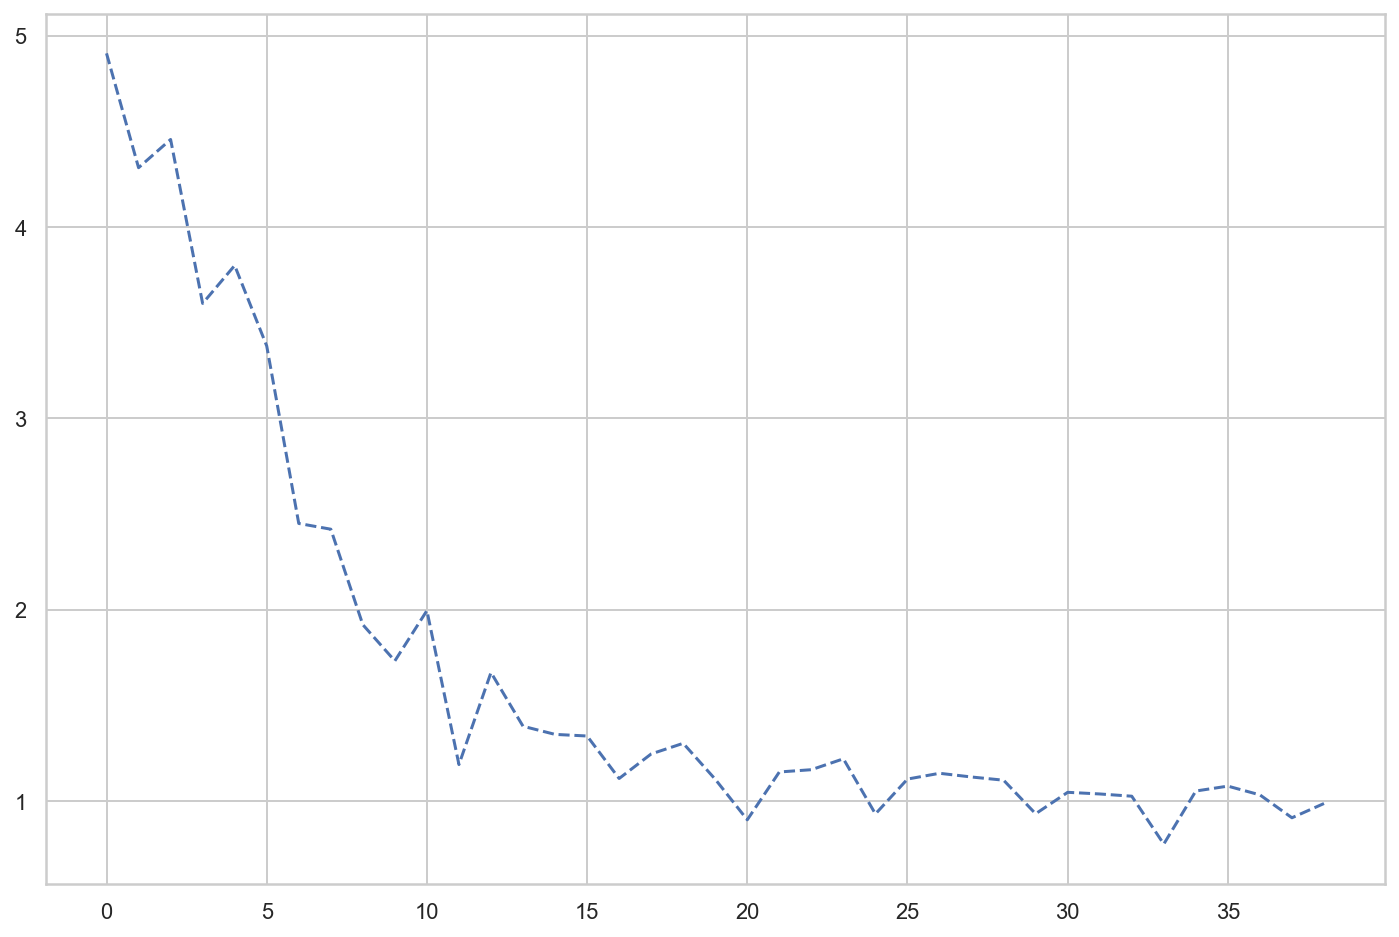

In [25]:
plt.figure(figsize=(12,8))
plt.plot(range(len(rmse_trace)), rmse_trace, 'b--')
plt.grid(True)
plt.show()

**Task:** Implement the RMSE test rating evaluation and plot along with the graph

In [26]:
def evaluate() -> List[float]:
    return rmse_trace

### Using the model for Recommendations

We have now created a model to describe users and items in terms of latent vectors. We fitted them to reconstruct ratings by multiplication. So for obtaining recommendations we simply multiply user-item latent vectors we are interested in and see favorable combinations where predicted ratings, i.e. the products, are rather high.

Thus, before writing the `get_recommendations` we first implement `get_prediction`.

In [27]:
def get_prediction(user, items: np.array = None, remove_known_pos: bool = False) -> Dict[int, Dict[str, float]]:
    if items is None:
        if remove_known_pos:
            # Predict from unobserved items
            known_items = np.array(list(user_ratings[user].keys()))
            items = np.setdiff1d(data.items, known_items)
        else:
            items = np.array(data.items)
    if type(items) == np.int64:
        items = np.array([items])
    
    user_embed = user_factors[user - 1].reshape(1, -1)
    item_embeds = item_factors[items - 1].reshape(len(items), -1)
    
    # use array-broadcasting
    preds = np.sum(user_embed * item_embeds, axis=1)
    sorting = np.argsort(preds)[::-1]
    preds = {item: {'pred': pred} for item, pred in
             zip(items[sorting], preds[sorting])}

    return preds

In [28]:
item_predictions = get_prediction(1)

In [29]:
item_predictions

{1647: {'pred': 5.550593346102936},
 408: {'pred': 5.433907312641124},
 178: {'pred': 5.3476561727278655},
 134: {'pred': 5.280254030193201},
 165: {'pred': 5.276198631644932},
 57: {'pred': 5.257832529693487},
 1194: {'pred': 5.238381014490929},
 45: {'pred': 5.2067952471363625},
 59: {'pred': 5.173452956274746},
 487: {'pred': 5.161424096766735},
 489: {'pred': 5.152329645514923},
 1153: {'pred': 5.124827888646395},
 500: {'pred': 5.121941526129773},
 316: {'pred': 5.111595223800425},
 114: {'pred': 5.109337309367081},
 642: {'pred': 5.102978943653667},
 269: {'pred': 5.096998725615163},
 995: {'pred': 5.093545478512582},
 483: {'pred': 5.090305181523024},
 89: {'pred': 5.076454385572095},
 488: {'pred': 5.055377201967358},
 709: {'pred': 5.050106903264331},
 313: {'pred': 5.03933949594493},
 515: {'pred': 5.034922026847322},
 787: {'pred': 5.033906859580385},
 60: {'pred': 5.032869285489473},
 242: {'pred': 5.027732405130416},
 64: {'pred': 5.022153128474397},
 302: {'pred': 4.99889

In [33]:
def get_recommendations(user: int, N: int, remove_known_pos: bool = False) -> List[Tuple[int, Dict[str, float]]]:
    predictions = get_prediction(user, remove_known_pos=remove_known_pos)
    recommendations = []
    for item, pred in predictions.items():
        add_item = (item, pred)
        recommendations.append(add_item)
        if len(recommendations) == N:
            break

    return recommendations

In [34]:
recommendations = get_recommendations(1, 10)

In [35]:
recommendations

[(1647, {'pred': 5.550593346102936}),
 (408, {'pred': 5.433907312641124}),
 (178, {'pred': 5.3476561727278655}),
 (134, {'pred': 5.280254030193201}),
 (165, {'pred': 5.276198631644932}),
 (57, {'pred': 5.257832529693487}),
 (1194, {'pred': 5.238381014490929}),
 (45, {'pred': 5.2067952471363625}),
 (59, {'pred': 5.173452956274746}),
 (487, {'pred': 5.161424096766735})]

### Evaluation

In [36]:
N = 10

In [37]:
relevant_items = get_relevant_items(data.test_ratings)

In [38]:
users = relevant_items.keys()
prec_at_N = dict.fromkeys(data.users)

for user in users:
    recommendations = get_recommendations(user, N, remove_known_pos=True)
    recommendations = [val[0] for val in recommendations]
    hits = np.intersect1d(recommendations,
                          relevant_items[user])
    prec_at_N[user] = len(hits)/N

In [39]:
recommendations

[787, 1348, 611, 647, 316, 408, 703, 1426, 1036, 694]

In [40]:
np.mean([val for val in prec_at_N.values() if val is not None])

0.010425531914893617